# Makemore
makemore will make more of whatever it is trained with.

In [1]:
words = open('names.txt', 'r').read().splitlines()

In [2]:
words[:10]

['emma',
 'olivia',
 'ava',
 'isabella',
 'sophia',
 'charlotte',
 'mia',
 'amelia',
 'harper',
 'evelyn']

Every word contains multiple examples in itself, as in, it tells us a certain character is likely to be followed by another particular character. So we can train a model on a text file, and then generate new words that are similar to the training data. It also tells us how likely is a word to end.

In [3]:
len(words)

32033

In [4]:
min(len(w) for w in words)

2

In [5]:
max(len(w) for w in words)

15

## Bigram Language Model
A bigram language model is a simple, weak language model that predicts the next character in a sequence based on the previous character. It only works on two characters at a time, and does not take into account the context of the previous characters, hence the name "bigram". It is a good place to start when building a language model, as it is easy to implement and understand. However, it is not very powerful and does not capture the complexity of natural language.

In [6]:
for w in words[:3]:
    # Wrapping each word with special start and end tokens.
    chs = ['<S>'] + list(w) + ['<E>']
    # Two chars at a time.
    for ch1, ch2 in zip(chs, chs[1:]):
        print(ch1, ch2)

<S> e
e m
m m
m a
a <E>
<S> o
o l
l i
i v
v i
i a
a <E>
<S> a
a v
v a
a <E>


The simplest way of learning about the statistics of which chars are likely to follow which other chars is to look at the training data and count how many times each pair of chars appears.
Let's check the stats for our dataset of names (`words`).

In [7]:
b = {}
for w in words:
    chs = ['<S>'] + list(w) + ['<E>']
    for ch1, ch2 in zip(chs, chs[1:]):
        bigram = (ch1, ch2)
        b[bigram] = b.get(bigram, 0) + 1

sorted(b.items(), key=lambda kv: -kv[1])

[(('n', '<E>'), 6763),
 (('a', '<E>'), 6640),
 (('a', 'n'), 5438),
 (('<S>', 'a'), 4410),
 (('e', '<E>'), 3983),
 (('a', 'r'), 3264),
 (('e', 'l'), 3248),
 (('r', 'i'), 3033),
 (('n', 'a'), 2977),
 (('<S>', 'k'), 2963),
 (('l', 'e'), 2921),
 (('e', 'n'), 2675),
 (('l', 'a'), 2623),
 (('m', 'a'), 2590),
 (('<S>', 'm'), 2538),
 (('a', 'l'), 2528),
 (('i', '<E>'), 2489),
 (('l', 'i'), 2480),
 (('i', 'a'), 2445),
 (('<S>', 'j'), 2422),
 (('o', 'n'), 2411),
 (('h', '<E>'), 2409),
 (('r', 'a'), 2356),
 (('a', 'h'), 2332),
 (('h', 'a'), 2244),
 (('y', 'a'), 2143),
 (('i', 'n'), 2126),
 (('<S>', 's'), 2055),
 (('a', 'y'), 2050),
 (('y', '<E>'), 2007),
 (('e', 'r'), 1958),
 (('n', 'n'), 1906),
 (('y', 'n'), 1826),
 (('k', 'a'), 1731),
 (('n', 'i'), 1725),
 (('r', 'e'), 1697),
 (('<S>', 'd'), 1690),
 (('i', 'e'), 1653),
 (('a', 'i'), 1650),
 (('<S>', 'r'), 1639),
 (('a', 'm'), 1634),
 (('l', 'y'), 1588),
 (('<S>', 'l'), 1572),
 (('<S>', 'c'), 1542),
 (('<S>', 'e'), 1531),
 (('j', 'a'), 1473),
 (

It will be more convenient for us to keep this info in a 2D array. The rows will be the first character, and the columns will be the second character. 

In [8]:
import torch
if torch.backends.mps.is_available():
    mps_device = torch.device("mps")
    torch.set_default_device(mps_device)

In [9]:
N = torch.zeros((27, 27), dtype=torch.int32)

In [10]:
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0

In [11]:
for w in words:
    chs = ['.'] + list(w) + ['.']
    for ch1, ch2 in zip(chs, chs[1:]):
        ix1 = stoi[ch1]
        ix2 = stoi[ch2]
        N[ix1, ix2] += 1

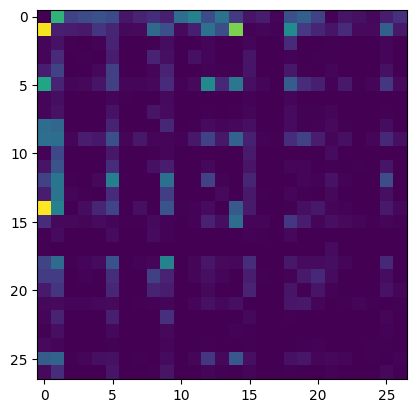

In [12]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.imshow(N.cpu())

(np.float64(-0.5), np.float64(26.5), np.float64(26.5), np.float64(-0.5))

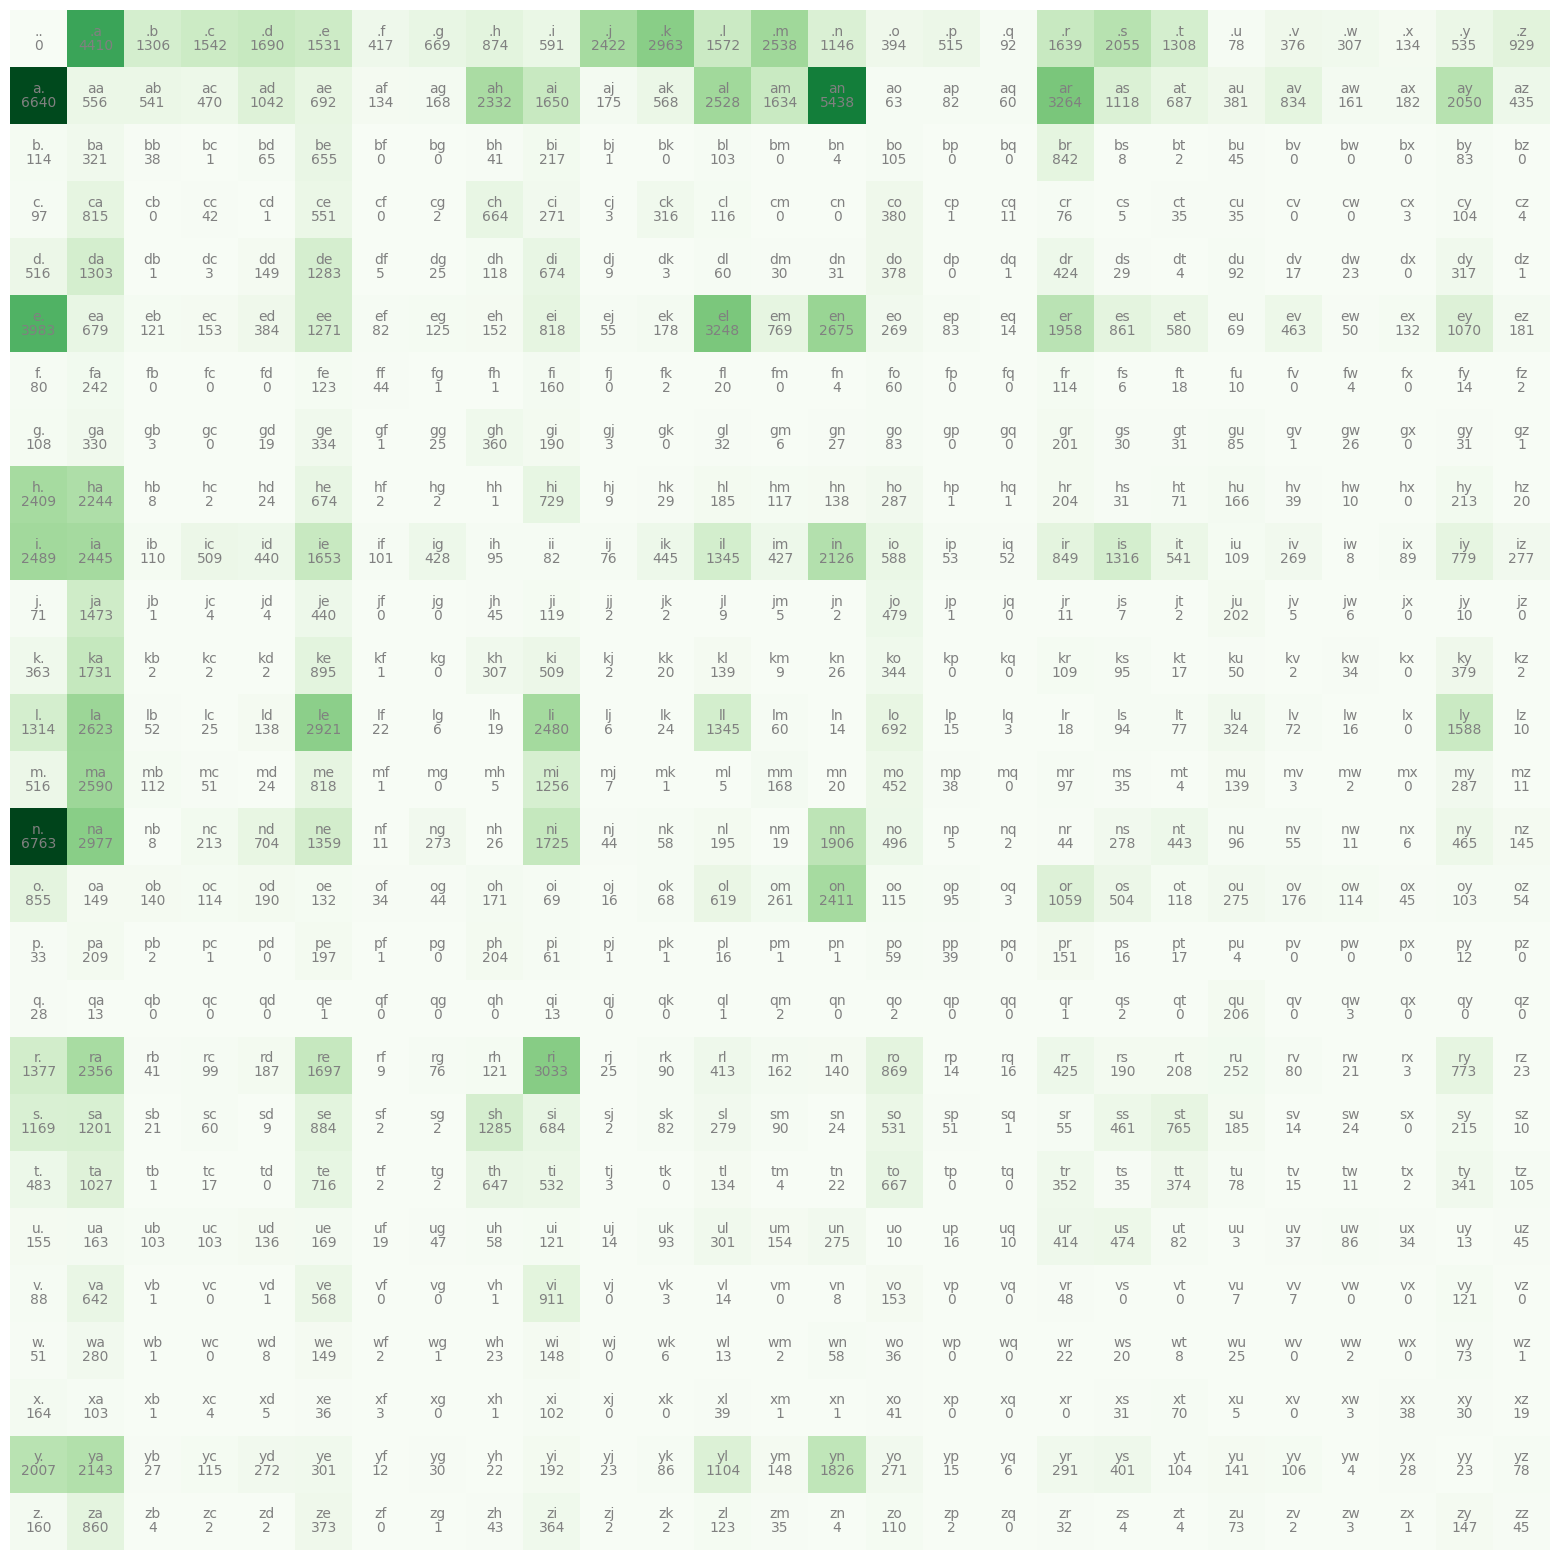

In [13]:
itos = {i:s for s,i in stoi.items()}

plt.figure(figsize=(20, 20))
plt.imshow(N.cpu(), cmap='Greens')
for i in range(27):
    for j in range(27):
        chstr = itos[i] + itos[j]
        plt.text(j, i, chstr, ha='center', va='bottom', color='gray')
        plt.text(j, i, str(N[i, j].item()), ha='center', va='top', color='gray')

plt.axis('off')

In [14]:
N[0]

tensor([   0, 4410, 1306, 1542, 1690, 1531,  417,  669,  874,  591, 2422, 2963,
        1572, 2538, 1146,  394,  515,   92, 1639, 2055, 1308,   78,  376,  307,
         134,  535,  929], device='mps:0', dtype=torch.int32)

In [15]:
p = N[0].float()
p = p / p.sum()  # normalize to get probabilities
p

tensor([0.0000, 0.1377, 0.0408, 0.0481, 0.0528, 0.0478, 0.0130, 0.0209, 0.0273,
        0.0184, 0.0756, 0.0925, 0.0491, 0.0792, 0.0358, 0.0123, 0.0161, 0.0029,
        0.0512, 0.0642, 0.0408, 0.0024, 0.0117, 0.0096, 0.0042, 0.0167, 0.0290],
       device='mps:0')

In [16]:
g = torch.Generator(device=mps_device).manual_seed(2147483647)
idx = torch.multinomial(p, num_samples=1, replacement=True, generator=g).item()
itos[idx]

'd'

In [17]:
g = torch.Generator(device=mps_device).manual_seed(2147483647)
p = torch.rand(3, generator=g)
p = p / p.sum()  # normalize to get probabilities
p

tensor([0.3999, 0.3954, 0.2047], device='mps:0')

In [18]:
torch.multinomial(p, num_samples=200, replacement=True, generator=g)

tensor([1, 0, 1, 2, 0, 0, 2, 1, 1, 1, 0, 0, 1, 1, 1, 2, 0, 2, 1, 0, 0, 0, 0, 0,
        2, 1, 1, 0, 1, 0, 2, 0, 2, 1, 1, 1, 1, 2, 2, 1, 0, 0, 1, 0, 0, 1, 0, 0,
        1, 2, 0, 1, 0, 0, 1, 2, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0,
        1, 1, 1, 0, 0, 0, 0, 1, 2, 0, 0, 0, 2, 0, 2, 0, 1, 2, 2, 0, 1, 0, 1, 2,
        1, 0, 1, 0, 1, 0, 2, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 2, 1, 2, 2, 1, 1, 0,
        1, 2, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 2, 0, 1, 0, 1, 0, 1,
        0, 0, 0, 0, 1, 1, 2, 2, 0, 2, 1, 1, 0, 2, 1, 2, 1, 1, 0, 2, 0, 1, 2, 0,
        1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 2, 2, 0,
        1, 1, 0, 2, 0, 2, 0, 1], device='mps:0')

In [19]:
P = (N+1).float()
P /= P.sum(dim=1, keepdim=True)  # Divide each row by its sum to get probabilities, instead of summing all elements.

Read up on pytorch broadcasting semantics. Will be important for the complex stuff when we reach Trasnformers.

In [20]:
g = torch.Generator(device=mps_device).manual_seed(2147483647)

for i in range(25):
    out = []
    idx = 0
    while True:
        p = P[idx]
        idx = torch.multinomial(p, num_samples=1, replacement=True, generator=g).item()
        out.append(itos[idx])
        if idx == 0:  # reached end token
            break

    print(''.join(out[:-1]))  # skip the last end token

daima
sason
odorsy
jarascevonn
ehirulystz
ceyn
th
kyn
coromarikorimolirrasi
k
ayanedin
eillanyusieke
ka
horly
kyiavy
be
rilellealdihaigmodan
jariyliler
onalydan
ja
arccaili
brya
mainil
byaaikonndamian
jo


The reason the names we generated look like gibberish is that we are sampling from the bigram distribution of characters, which does not capture the full context of the words. To improve this, we can use a more sophisticated model like an RNN or a Transformer that can learn longer dependencies in the data.
This will allow us to generate names that are more coherent and resemble real names better.

The goal is to maximise the likelihood of the data w.r.t. the model parameters (statistical modeling).
This is equivalent to maximizing the log likelihood of the data (because log likelihood is a monotonic function).
This is equivalent to minimizing the negative log likelihood of the data (because minimizing a function is equivalent to maximizing its negative).
This is also equivalent to minimising the average negative log likelihood of the data (because we can divide by the number of data points to get the average).

Mathematically, we know:
log(a*b*c) = log(a) + log(b) + log(c)

In [21]:
log_likelihood = 0.0
n = 0

for w in words:
    chs = ['.'] + list(w) + ['.']
    for ch1, ch2 in zip(chs, chs[1:]):
        ix1 = stoi[ch1]
        ix2 = stoi[ch2]
        prob = P[ix1, ix2]
        log_likelihood += torch.log(prob)
        n += 1

print(f'{log_likelihood=}')
nll = -log_likelihood
print(f'{nll=}')
print(f'{nll/n}')

log_likelihood=tensor(-559951.5625, device='mps:0')
nll=tensor(559951.5625, device='mps:0')
2.4543561935424805


# The Neural Network Approach

Let's start by creating a training set of bigrams.

In [22]:
# Inputs (xs) and targets (ys) for training.
# xs will be the first character of each bigram, and ys will be the second character
xs, ys = [], []

for w in words:
    chs = ['.'] + list(w) + ['.']
    for ch1, ch2 in zip(chs, chs[1:]):
        ix1 = stoi[ch1]
        ix2 = stoi[ch2]
        xs.append(ix1)
        ys.append(ix2)
    
xs = torch.tensor(xs, device=mps_device)
ys = torch.tensor(ys, device=mps_device)

In [23]:
xs

tensor([ 0,  5, 13,  ..., 25, 26, 24], device='mps:0')

In [24]:
ys

tensor([ 5, 13, 13,  ..., 26, 24,  0], device='mps:0')

In [25]:
import torch.nn.functional as F

x_enc = F.one_hot(xs, num_classes=27).float()  # One-hot encode the input indices
x_enc.shape

torch.Size([228146, 27])

In [26]:
x_enc

tensor([[1., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 1., 0.],
        [0., 0., 0.,  ..., 0., 0., 1.],
        [0., 0., 0.,  ..., 1., 0., 0.]], device='mps:0')

In [27]:
x_enc.dtype

torch.float32

In [28]:
W = torch.randn((27, 27), device=mps_device) # Initialize weights
x_enc @ W 

tensor([[ 0.1461, -0.3629,  1.0026,  ...,  0.2783, -0.6385, -0.0595],
        [ 0.2570, -0.6455, -2.0672,  ..., -2.3197,  1.4207,  0.1668],
        [-0.3874,  0.1945,  0.7076,  ...,  0.2903,  0.7716,  0.4100],
        ...,
        [-1.2568, -2.0759, -0.1003,  ..., -0.5186, -0.5766,  0.4847],
        [-0.3529,  0.4137, -0.7040,  ..., -0.2501, -1.9045, -0.2767],
        [-1.5903,  0.9807,  0.1820,  ...,  1.2464, -0.3685, -2.2471]],
       device='mps:0')

In [29]:
logits = x_enc @ W # log-counts
counts = logits.exp()  # Convert log-counts to counts
probs = counts / counts.sum(dim=1, keepdim=True)  # Normalize to get probabilities
probs

tensor([[0.0216, 0.0130, 0.0509,  ..., 0.0247, 0.0099, 0.0176],
        [0.0361, 0.0147, 0.0035,  ..., 0.0027, 0.1157, 0.0330],
        [0.0186, 0.0332, 0.0555,  ..., 0.0366, 0.0592, 0.0412],
        ...,
        [0.0064, 0.0028, 0.0204,  ..., 0.0134, 0.0127, 0.0366],
        [0.0148, 0.0318, 0.0104,  ..., 0.0164, 0.0031, 0.0160],
        [0.0057, 0.0743, 0.0334,  ..., 0.0969, 0.0193, 0.0029]],
       device='mps:0')

In [30]:
probs.shape

torch.Size([228146, 27])

In [31]:
probs[0].sum()

tensor(1., device='mps:0')

In [32]:
probs[0]

tensor([0.0216, 0.0130, 0.0509, 0.0201, 0.0741, 0.0208, 0.0082, 0.0479, 0.0427,
        0.0729, 0.0037, 0.0267, 0.0327, 0.0096, 0.0068, 0.0138, 0.1175, 0.0092,
        0.0736, 0.1725, 0.0288, 0.0189, 0.0447, 0.0171, 0.0247, 0.0099, 0.0176],
       device='mps:0')

In [33]:
probs[0].shape

torch.Size([27])

In [34]:
# Randomly init 27 neuron weights. Each neuron recieves 27 inputs
g = torch.Generator(device=mps_device).manual_seed(2147483647)
W = torch.randn((27, 27), device=mps_device, generator=g, requires_grad=True) # Initialize weights

In [35]:
# Regularization term: mean of squares of weights
(W**2).mean()

tensor(0.9991, device='mps:0', grad_fn=<MeanBackward0>)

In [36]:
learning_rate = -10
for i in range(1000):
    # Forward Pass
    xenc = F.one_hot(xs, num_classes=27).float()  # One-hot encode the input indices
    logits = xenc @ W # Predicts log-counts
    counts = logits.exp()  # Convert log-counts to counts, equivalent to N
    probs = counts / counts.sum(dim=1, keepdim=True)  # Normalize to get probabilities
    # Last 2 lines together are called 'softmax'

    reg_loss = 0.01 * (W**2).mean()  # Regularization term: mean of squares of weights
    loss = -probs[torch.arange(xs.shape[0]), ys].log().mean() + reg_loss  # Negative log likelihood loss + regularization

    # Backward Pass
    W.grad = None  # Reset gradients
    loss.backward()  # Compute gradients

    # Update Weights
    W.data += learning_rate * W.grad  # Update weights
    if (i+1) % 100 == 0:
        print(f'Iteration {i+1}, Loss: {loss.item()}')


Iteration 100, Loss: 2.5810749530792236
Iteration 200, Loss: 2.5209977626800537
Iteration 300, Loss: 2.5029518604278564
Iteration 400, Loss: 2.4946963787078857
Iteration 500, Loss: 2.4901726245880127
Iteration 600, Loss: 2.4874298572540283
Iteration 700, Loss: 2.485651969909668
Iteration 800, Loss: 2.484440326690674
Iteration 900, Loss: 2.4835822582244873
Iteration 1000, Loss: 2.4829554557800293


In [37]:
# nlls = torch.zeros(xs.shape[0], device=mps_device)
# for i in range(xs.shape[0]):
#     # i-th bigram
#     x = xs[i].item() # Input Character
#     y = ys[i].item() # Target Character
#     p = probs[i, y]  # Probability of the target character given the input character
#     logp = torch.log(p)  # Log probability
#     nll = -logp  # Negative log likelihood
#     nlls[i] = nll  # Store the negative log likelihood for the i-th bigram
    

In [38]:
# print(f'{nlls.mean().item()=}')

## Sampling from the neural network model

In [39]:
g = torch.Generator(device=mps_device).manual_seed(2147483647)

for i in range(25):
    out = []
    idx = 0
    while True:
        # Before
        # p = P[idx]

        # Now
        x_enc = F.one_hot(torch.tensor([idx]), num_classes=27).float()
        logits = x_enc @ W
        counts = logits.exp()
        p = counts / counts.sum(dim=1, keepdim=True)

        idx = torch.multinomial(p, num_samples=1, replacement=True, generator=g).item()
        out.append(itos[idx])
        if idx == 0:  # reached end token
            break


    print(''.join(out[:-1]))  # skip the last end token

daima
sason
odorsy
jarascevonn
ehirulystz
ceyn
th
kyn
coromarikorimolirrasi
k
ayanedin
eillanyusieke
ka
horly
kyiavy
be
rilellealdqudigmodan
jariyliler
onalydan
ja
arccaili
brya
mainil
byaaikonndamian
jo
